In [1]:
!pip install xgboost imbalanced-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: C:\Users\Tanishka Mali\AppData\Local\Programs\Python\Python313\python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                            f1_score, classification_report, confusion_matrix, 
                            ConfusionMatrixDisplay, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
df = pd.read_csv("C:/Users/Tanishka Mali/final(2).csv/ransap.csv")

In [4]:
print("Dataset shape:", df.shape)

Dataset shape: (149043, 14)


In [5]:
print("\nDataset columns:", df.columns.tolist())


Dataset columns: ['Time', 'Protcol', 'Flag', 'Family', 'Clusters', 'SeddAddress', 'ExpAddress', 'BTC', 'USD', 'Netflow_Bytes', 'IPaddress', 'Threats', 'Port', 'Prediction']


In [6]:
print("\nFirst 5 rows:\n", df.head())


First 5 rows:
    Time Protcol Flag    Family  Clusters SeddAddress ExpAddress  BTC  USD  \
0    50     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  500   
1    40     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  504   
2    30     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  508   
3    20     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  512   
4    57     TCP    A  WannaCry         1    1DA11mPS   1BonuSr7    1  516   

   Netflow_Bytes IPaddress Threats  Port Prediction  
0              5         A   Bonet  5061         SS  
1              8         A   Bonet  5061         SS  
2              7         A   Bonet  5061         SS  
3             15         A   Bonet  5061         SS  
4              9         A   Bonet  5061         SS  


In [7]:
print("\nMissing values:")
print(df.isnull().sum().sum())  # Total missing values


Missing values:
0


In [8]:
df = df.dropna()

In [9]:
print("Data types:\n", df.dtypes)

Data types:
 Time              int64
Protcol          object
Flag             object
Family           object
Clusters          int64
SeddAddress      object
ExpAddress       object
BTC               int64
USD               int64
Netflow_Bytes     int64
IPaddress        object
Threats          object
Port              int64
Prediction       object
dtype: object


In [10]:
print("Unique values in 'Prediction':", df['Prediction'].unique())

Unique values in 'Prediction': ['SS' 'A' 'S']


In [11]:
# 1. Verify label meanings (crucial for malware detection)
print("Label meanings:")
print("SS:", df[df['Prediction'] == 'SS'].shape[0], "samples")
print("A:", df[df['Prediction'] == 'A'].shape[0], "samples")
print("S:", df[df['Prediction'] == 'S'].shape[0], "samples")

Label meanings:
SS: 40102 samples
A: 42561 samples
S: 66380 samples


In [12]:
# Convert labels and drop columns
label_map = {'SS': 0, 'A': 1, 'S': 2}
df['Prediction'] = df['Prediction'].map(label_map)
df = df.drop(['IPaddress', 'Time'], axis=1)

In [13]:
# Define features
categorical_features = ['Protcol', 'Flag', 'Family', 'SeddAddress', 'ExpAddress', 'Threats']
numerical_features = ['Clusters', 'BTC', 'USD', 'Netflow_Bytes', 'Port']

In [14]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

In [15]:
# ------ Train-Test Split ------
X = df.drop('Prediction', axis=1)
y = df['Prediction']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [16]:
# Separate preprocessing and resampling
resampler = Pipeline([
    ('preprocessor', preprocessor),
    ('oversample', SMOTE(sampling_strategy={0: 42000, 1: 38000}, random_state=42)),
    ('undersample', RandomUnderSampler(sampling_strategy={2: 37000}, random_state=42))
])

In [17]:
# Apply resampling
X_res, y_res = resampler.fit_resample(X_train, y_train)

In [18]:
# ------ Model Training ------
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

results = {}

for name, model in models.items():
    # Train directly on preprocessed data
    model.fit(X_res, y_res)
    
    # Preprocess test data
    X_test_preprocessed = preprocessor.transform(X_test)
    
    # Make predictions
    y_pred = model.predict(X_test_preprocessed)
    y_proba = model.predict_proba(X_test_preprocessed)
    
    # Store results
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted'),
        'cm': confusion_matrix(y_test, y_pred),
        'report': classification_report(y_test, y_pred, target_names=label_map.keys()),
        'proba': y_proba
    }

C:\Users\Tanishka Mali\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:28:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [19]:
# Metrics comparison
metrics_df = pd.DataFrame({
    'Model': results.keys(),
    'Accuracy': [res['accuracy'] for res in results.values()],
    'Precision': [res['precision'] for res in results.values()],
    'Recall': [res['recall'] for res in results.values()],
    'F1-Score': [res['f1'] for res in results.values()]
}).set_index('Model')

print("\nModel Performance Comparison:")
print(metrics_df)


Model Performance Comparison:
                     Accuracy  Precision    Recall  F1-Score
Model                                                       
Logistic Regression  0.879230   0.881770  0.879230  0.879560
Random Forest        0.988191   0.988199  0.988191  0.988189
XGBoost              0.990629   0.990668  0.990629  0.990626


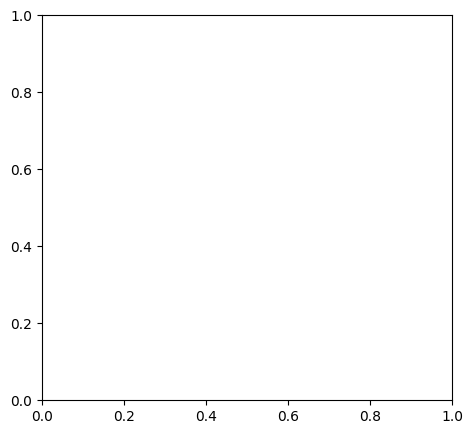

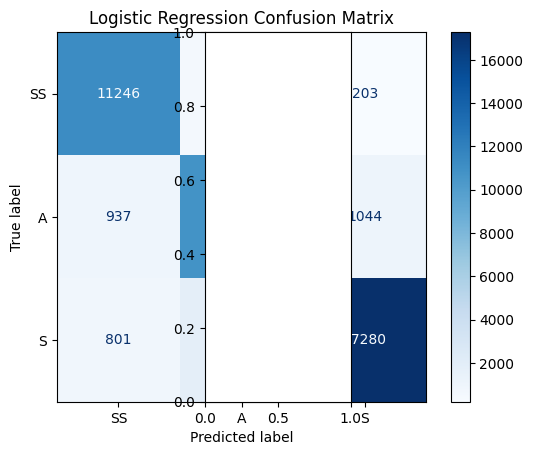

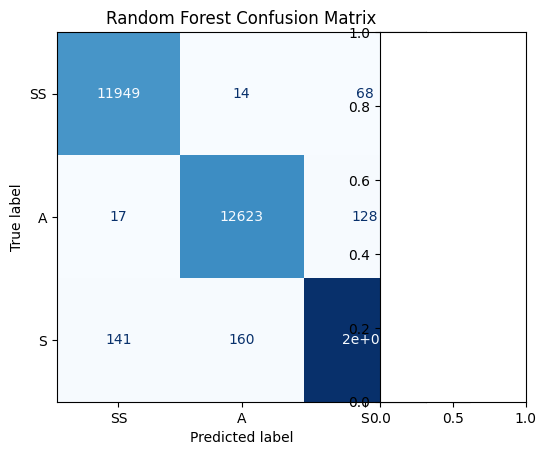

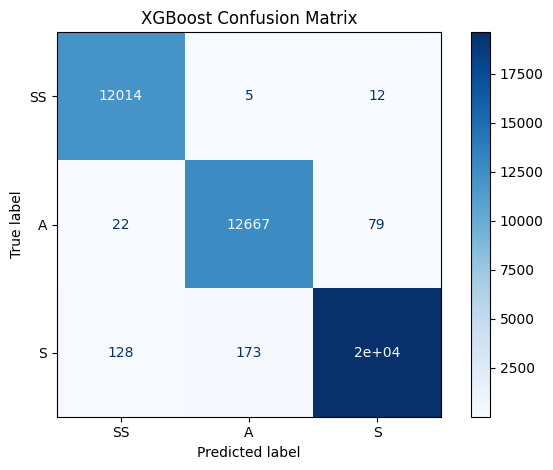

In [20]:
# Confusion matrices
plt.figure(figsize=(18, 5))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    ConfusionMatrixDisplay(res['cm'], display_labels=label_map.keys()).plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
plt.tight_layout()
plt.show()

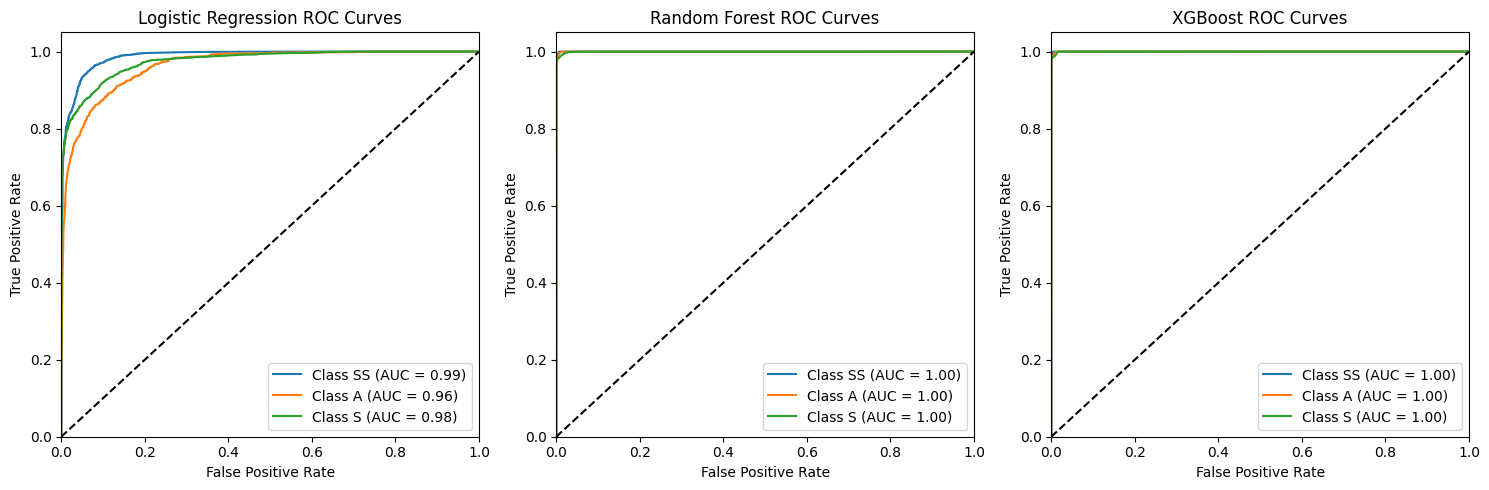

In [21]:
# ROC Curves
plt.figure(figsize=(15, 5))
for i, (name, res) in enumerate(results.items(), 1):
    plt.subplot(1, 3, i)
    
    # Calculate ROC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for c in range(3):
        fpr[c], tpr[c], _ = roc_curve(y_test == c, res['proba'][:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])
        plt.plot(fpr[c], tpr[c], label=f'Class {list(label_map.keys())[c]} (AUC = {roc_auc[c]:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curves')
    plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

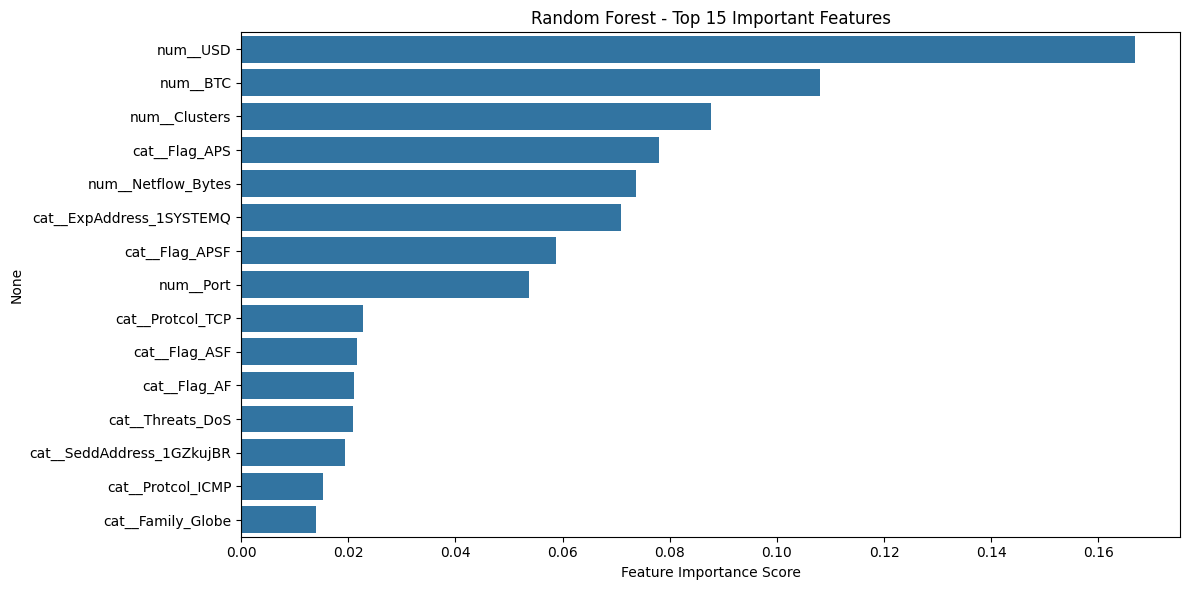

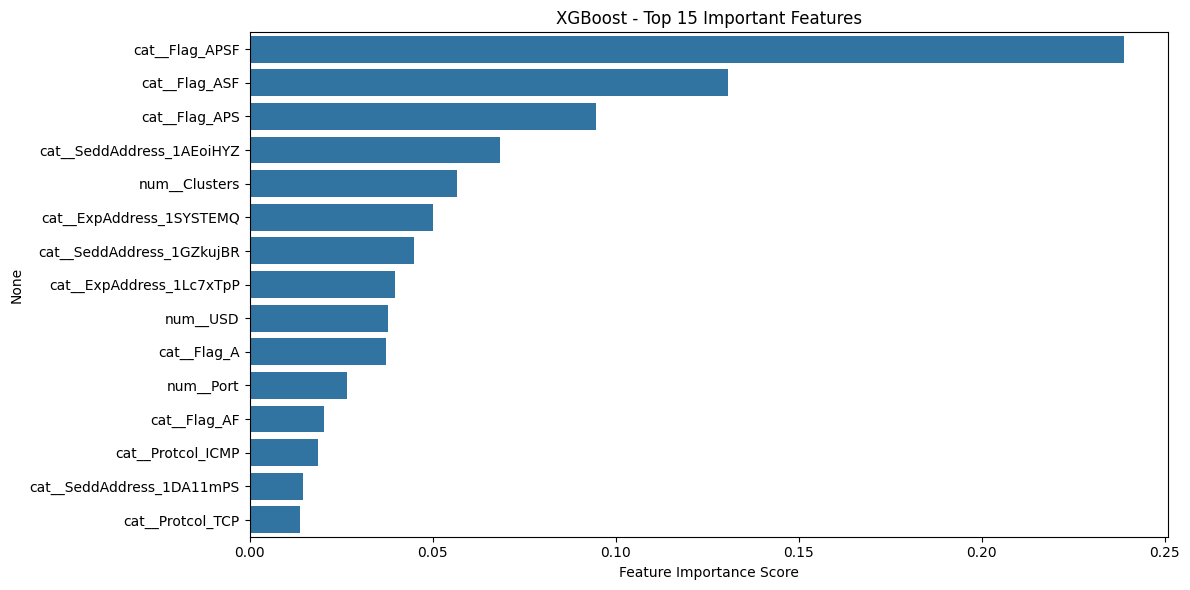

In [23]:
# Feature Importance (Corrected)
for name in ['Random Forest', 'XGBoost']:
    model = models[name]  # Get the trained model directly
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        features = preprocessor.get_feature_names_out()
        feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)[:15]
        
        plt.figure(figsize=(12, 6))
        sns.barplot(x=feat_imp.values, y=feat_imp.index)
        plt.title(f'{name} - Top 15 Important Features')
        plt.xlabel('Feature Importance Score')
        plt.tight_layout()
        plt.show()

In [24]:
# Classification reports
print("\nDetailed Reports:")
for name, res in results.items():
    print(f"\n{name} Classification Report:")
    print(res['report'])


Detailed Reports:

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          SS       0.87      0.93      0.90     12031
           A       0.82      0.84      0.83     12768
           S       0.93      0.87      0.90     19914

    accuracy                           0.88     44713
   macro avg       0.87      0.88      0.88     44713
weighted avg       0.88      0.88      0.88     44713


Random Forest Classification Report:
              precision    recall  f1-score   support

          SS       0.99      0.99      0.99     12031
           A       0.99      0.99      0.99     12768
           S       0.99      0.98      0.99     19914

    accuracy                           0.99     44713
   macro avg       0.99      0.99      0.99     44713
weighted avg       0.99      0.99      0.99     44713


XGBoost Classification Report:
              precision    recall  f1-score   support

          SS       0.99      1.00      0.99     12